In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import display, clear_output
from math import ceil
from datetime import datetime
from pathlib import Path

In [3]:
# Nombres legibles para universidades
university_labels = {
    "uach-mf": "UACh Miraflores",
    "uach-teja": "UACh Campus Isla Teja",
    "uss": "USS Valdivia",
    "ust": "UST Valdivia",
    "inacap": "INACAP Valdivia"
}

# Nombres legibles para supermercados
supermarket_labels = {
    "acuenta": "aCuenta",
    "eltit": "Eltit",
    "eltrebol": "El Trébol",
    "jumbo": "Jumbo",
    "santaisabel": "Santa Isabel",
    "unimarc": "Unimarc"
}

def plot_supermarket_distances(df, university, supermarkets=None):
    uni_data = df[df['university'] == university]
    
    if uni_data.empty:
        print(f"No se encontraron datos para la universidad: {university}")
        return

    if supermarkets is not None:
        # Crear patrón de regex para buscar cualquier supermercado que comience con los nombres dados
        pattern = '|'.join([f'^{s}' for s in supermarkets])
        uni_data = uni_data[uni_data['supermarket'].str.contains(pattern)]
        
        if uni_data.empty:
            print(f"No se encontraron supermercados que coincidan con: {supermarkets}")
            return
    
    uni_data = uni_data.sort_values('distance')
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(uni_data['supermarket'], uni_data['distance'], color='skyblue')
    
    plt.title(f'Distancias de supermercados a {university_labels.get(university, university)}', fontsize=14)
    plt.xlabel('Supermercado', fontsize=12)
    plt.ylabel('Distancia (metros)', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    
    plt.show()

df = pd.read_csv('./utils/distance-to-nearest-supermarket/distances.csv')    
uni_dropdown = ipw.Dropdown(
    options=[(label, key) for key, label in university_labels.items()],
    layout=ipw.Layout(width='200px')
)

supermarket_brands = sorted(set(s.split('_')[0] for s in df['supermarket'].unique()))
checkboxes = []
checkbox_map = {}

for key, label in supermarket_labels.items():
    checkbox = ipw.Checkbox(value=True, description=label)
    checkboxes.append(checkbox)
    checkbox_map[checkbox] = key

half = ceil(len(checkboxes)/2)
left_col = ipw.VBox(checkboxes[:half])
right_col = ipw.VBox(checkboxes[half:])
checkboxes_grid = ipw.HBox([left_col, right_col])

# Botón para generar el gráfico
run_button = ipw.Button(description="Generar Gráfico")

# Botón para mostrar glosario
glossary_button = ipw.Button(
    description="Ver Glosario de Supermercados",
    button_style="info",
    layout=ipw.Layout(width='250px')
)

glossary_output = ipw.Output()

supermarket_glossary = {
    "aCuenta": [
        "Pedro Montt 4300, Valdivia",
        "Av. Ramón Picarte 2661, Valdivia",
        "Carlos Anwandter 930, Valdivia"
    ],
    "Eltit": [
        "Camilo Henríquez 780, Valdivia"
    ],
    "El Trébol": [
        "Av. Simpson 499, Valdivia",
        "René Schneider 3722, Valdivia"
    ],
    "Jumbo": [
        "Errázuriz 1040, Valdivia"
    ],
    "Líder": [
        "Coronel Santiago Bueras 1400, Valdivia"
    ],
    "Santa Isabel": [
        "Chacabuco 545, Valdivia",
        "Av. Ramón Picarte 3057, Valdivia"
    ],
    "Unimarc": [
        "Av. Francia 2651, Valdivia",
        "Arauco 697, Valdivia",
        "Yungay 420, Valdivia",
        "Av. Pedro Aguirre Cerda 400, Valdivia"
    ]
}

right_controls = ipw.VBox([
    ipw.Label("Distancias a universidad:"),
    uni_dropdown,
    run_button
], layout=ipw.Layout(align_items='center'))

graph_output = ipw.Output()

top_layout = ipw.HBox([
    graph_output,
])

left_controls = ipw.VBox([
    ipw.Label("Filtrar por:"),
    checkboxes_grid
], layout=ipw.Layout(align_items='center'))

center_layout = ipw.HBox([
    left_controls,
    right_controls
], layout=ipw.Layout(align_items='center'))

bottom_layout = ipw.VBox([
    glossary_button,
    glossary_output
], layout=ipw.Layout(align_items='center'))

# 5. Contenedor final
main_layout = ipw.VBox([
    top_layout,
    center_layout,
    bottom_layout
])

glossary_printed = False

def on_run_button_clicked(b):
    with graph_output:
        clear_output(wait=True)
        
        selected_brands = [checkbox_map[cb] for cb in checkboxes if cb.value]
        
        plot_supermarket_distances(df, uni_dropdown.value, selected_brands)

def show_glossary(b):
    with glossary_output:
        clear_output()
        print("Glosario de supermercados y sus direcciones:\n")
        for name, addresses in supermarket_glossary.items():
            print(f"{name}:")
            i = 1
            
            for addr in addresses:
                print(f"  {i}. {addr}")
                i += 1
            print()

run_button.on_click(on_run_button_clicked)
glossary_button.on_click(show_glossary)

# Mostrar la interfaz
display(main_layout)

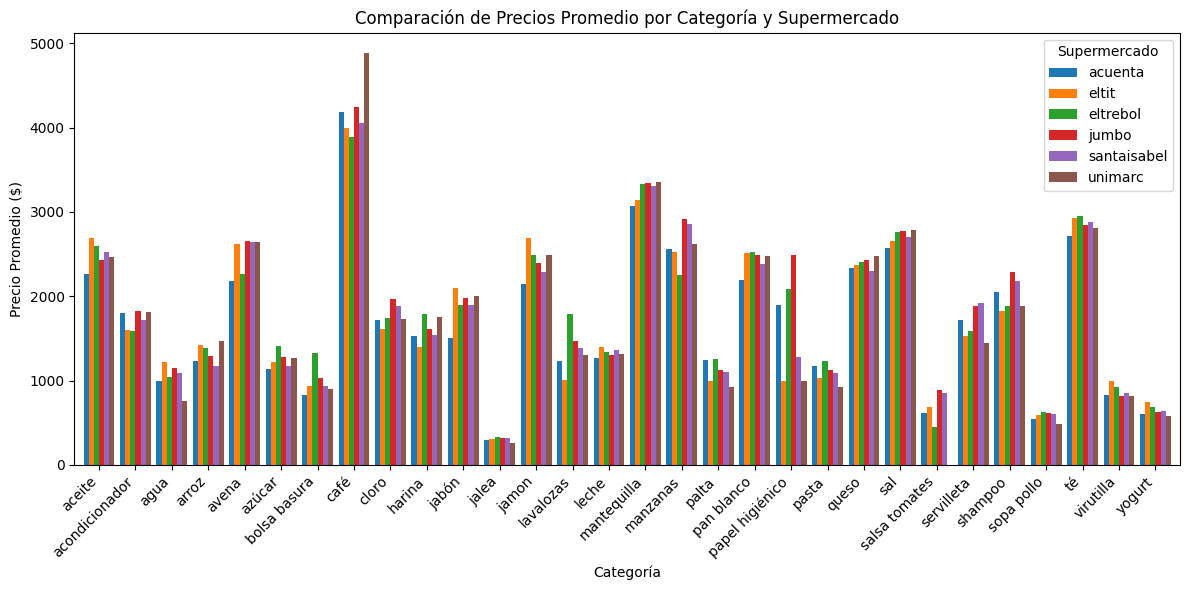

In [14]:
def graficar_promedio_por_categoria(fecha_inicio, fecha_fin, supermercados=None):
    carpeta = Path("./utils/common-products-filter/results/")
    archivos = sorted([f for f in carpeta.iterdir() if f.suffix == '.csv'])

    fecha_inicio = datetime.strptime(fecha_inicio, '%d-%m-%Y')
    fecha_fin = datetime.strptime(fecha_fin, '%d-%m-%Y')

    dfs = []

    for archivo in archivos:
        try:
            fecha = datetime.strptime(archivo.stem, '%d-%m-%Y')
        except ValueError:
            continue
        
        if fecha_inicio <= fecha <= fecha_fin:
            df = pd.read_csv(archivo)
            df["fecha"] = fecha
            dfs.append(df)

    if not dfs:
        print("⚠️ No se encontraron archivos en ese rango de fechas.")
        return

    df_total = pd.concat(dfs, ignore_index=True)

    # Detectar supermercados automáticamente desde columnas que comienzan con "price_"
    columnas_supermercado = [col for col in df_total.columns if col.startswith("price_")]
    supermercados_disponibles = [col.replace("price_", "") for col in columnas_supermercado]

    if supermercados is None:
        supermercados = supermercados_disponibles
    else:
        supermercados = [s for s in supermercados if s in supermercados_disponibles]

    if not supermercados:
        print("⚠️ No hay supermercados válidos para mostrar.")
        return

    # Crear DataFrame de promedios por categoría y supermercado
    datos_promedio = []
    for supermercado in supermercados:
        col_precio = f"price_{supermercado}"
        temp = df_total[["search", col_precio]].copy()
        temp.columns = ["search", "price"]
        temp["supermercado"] = supermercado
        datos_promedio.append(temp)

    df_promedios = pd.concat(datos_promedio, ignore_index=True)
    df_resultado = df_promedios.groupby(["search", "supermercado"])["price"].mean().reset_index()

    # Pivot para gráfico
    df_pivot = df_resultado.pivot(index="search", columns="supermercado", values="price")

    # Graficar
    ax = df_pivot.plot(kind="bar", figsize=(12, 6), width=0.85)
    plt.title("Comparación de Precios Promedio por Categoría y Supermercado")
    plt.ylabel("Precio Promedio ($)")
    plt.xlabel("Categoría")
    plt.xticks(rotation=45, ha='right')

    # Etiquetas en las barras
    #for container in ax.containers:
    #    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

    plt.legend(title="Supermercado")
    plt.tight_layout()
    plt.show()

options = []
with open("./scrappers/acuenta/search.txt", 'r', encoding='utf-8') as file:
    for linea in file:
        options.append(linea.strip().replace("\n", ""))
        
uni_dropdown = ipw.Dropdown(
    options=options
    layout=ipw.Layout(width='200px')
)

supermarket_brands = sorted(set(s.split('_')[0] for s in df['supermarket'].unique()))
checkboxes = []
checkbox_map = {}

for key, label in supermarket_labels.items():
    checkbox = ipw.Checkbox(value=True, description=label)
    checkboxes.append(checkbox)
    checkbox_map[checkbox] = key

half = ceil(len(checkboxes)/2)
left_col = ipw.VBox(checkboxes[:half])
right_col = ipw.VBox(checkboxes[half:])
checkboxes_grid = ipw.HBox([left_col, right_col])

# Botón para generar el gráfico
run_button = ipw.Button(description="Generar Gráfico")

# Botón para mostrar glosario
glossary_button = ipw.Button(
    description="Ver Glosario de Supermercados",
    button_style="info",
    layout=ipw.Layout(width='250px')
)

glossary_output = ipw.Output()

supermarket_glossary = {
    "aCuenta": [
        "Pedro Montt 4300, Valdivia",
        "Av. Ramón Picarte 2661, Valdivia",
        "Carlos Anwandter 930, Valdivia"
    ],
    "Eltit": [
        "Camilo Henríquez 780, Valdivia"
    ],
    "El Trébol": [
        "Av. Simpson 499, Valdivia",
        "René Schneider 3722, Valdivia"
    ],
    "Jumbo": [
        "Errázuriz 1040, Valdivia"
    ],
    "Líder": [
        "Coronel Santiago Bueras 1400, Valdivia"
    ],
    "Santa Isabel": [
        "Chacabuco 545, Valdivia",
        "Av. Ramón Picarte 3057, Valdivia"
    ],
    "Unimarc": [
        "Av. Francia 2651, Valdivia",
        "Arauco 697, Valdivia",
        "Yungay 420, Valdivia",
        "Av. Pedro Aguirre Cerda 400, Valdivia"
    ]
}

right_controls = ipw.VBox([
    ipw.Label("Distancias a universidad:"),
    uni_dropdown,
    run_button
], layout=ipw.Layout(align_items='center'))

graph_output = ipw.Output()

top_layout = ipw.HBox([
    graph_output,
])

left_controls = ipw.VBox([
    ipw.Label("Filtrar por:"),
    checkboxes_grid
], layout=ipw.Layout(align_items='center'))

center_layout = ipw.HBox([
    left_controls,
    right_controls
], layout=ipw.Layout(align_items='center'))

bottom_layout = ipw.VBox([
    glossary_button,
    glossary_output
], layout=ipw.Layout(align_items='center'))

# 5. Contenedor final
main_layout = ipw.VBox([
    top_layout,
    center_layout,
    bottom_layout
])

glossary_printed = False

def on_run_button_clicked(b):
    with graph_output:
        clear_output(wait=True)
        
        selected_brands = [checkbox_map[cb] for cb in checkboxes if cb.value]
        
        plot_supermarket_distances(df, uni_dropdown.value, selected_brands)

def show_glossary(b):
    with glossary_output:
        clear_output()
        print("Glosario de supermercados y sus direcciones:\n")
        for name, addresses in supermarket_glossary.items():
            print(f"{name}:")
            i = 1
            
            for addr in addresses:
                print(f"  {i}. {addr}")
                i += 1
            print()

run_button.on_click(on_run_button_clicked)
glossary_button.on_click(show_glossary)

# Mostrar la interfaz
display(main_layout)